In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math

In [2]:
my_image_path_1 = os.getenv('HOME')+'/aiffel/my_pictures/my_picture_1.jpg'
my_image_path_2 = os.getenv('HOME')+'/aiffel/my_pictures/my_picture_2.jpg'
my_image_path_3 = os.getenv('HOME')+'/aiffel/my_pictures/my_picture_3.jpg'
my_image_path_4 = os.getenv('HOME')+'/aiffel/my_pictures/my_picture_4.jpg'
img_bgr = cv2.imread(my_image_path_1)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
#plt.imshow(img_bgr)
#plt.show()

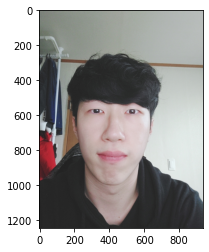

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
detector_hog = dlib.get_frontal_face_detector()

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(194, 451) (656, 913)]]


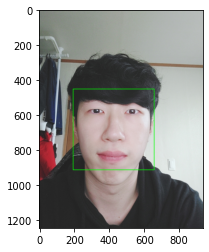

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


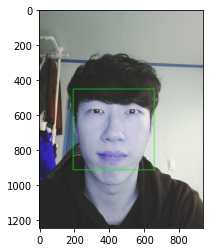

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(424, 713)
(x,y) : (424,482)
(w,h) : (463,463)


In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(463, 463, 3)


In [12]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (193,19)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (193,19)


In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

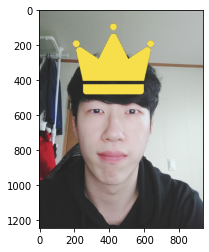

In [15]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 응용

In [16]:
#두 점 사이의 거리
def distance(vector1,vector2):
    x = abs(vector1[0]-vector2[0])*abs(vector1[0]-vector2[0])
    y = abs(vector1[1]-vector2[1])*abs(vector1[1]-vector2[1])
    return np.sqrt(x+y)

In [17]:
#적절한 회전 각도를 반환
def get_rotate(vector1,vector2):
    
    dist1 = distance(vector1,vector2)
    dist2 = abs(vector1[1]-vector2[1])
    #각도 변환
    rotate = math.asin(dist2/dist1)*(180/math.pi)
    if(vector1[0] < vector2[0]):
        rotate += 90
    if(vector1[1] > vector2[1]):
        rotate = -rotate
    return rotate

In [18]:
#함수화
def my_selca(img_path):
    img_bgr = cv2.imread(img_path)
    img_show = img_bgr.copy()
    
    detector_hog = dlib.get_frontal_face_detector()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    #이미 학습된 모델 호출
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    list_landmarks = []
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    #좌표 설정
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # 코의 index는 30 입니다
        x = landmark[30][0]
        y = landmark[30][1] - dlib_rect.height()//2
        w = h = dlib_rect.width()    
        
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)
    
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    rotate = get_rotate(landmark[13],landmark[33])
    #print(rotate)
    img_rotate = cv2.getRotationMatrix2D((w/2,h/2),rotate,1)
    img_sticker = cv2.warpAffine(img_sticker,img_rotate,(w,h))
    refined_x = x - w // 2
    refined_y = y - h
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.5, 0)
    #투명한 왕관 씌우기이이
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

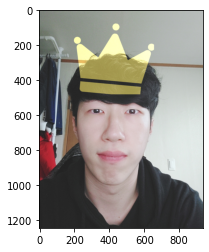

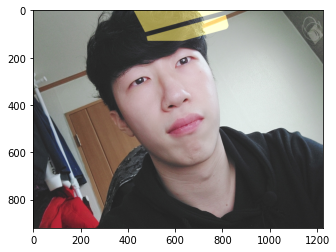

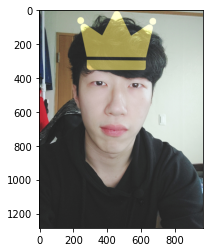

In [19]:
my_selca(my_image_path_1)
my_selca(my_image_path_2)
my_selca(my_image_path_3)

In [20]:
#고양이 수염 적용(이미지 회전 적용)
def my_selca_2(img_path):
    img_bgr = cv2.imread(img_path)
    img_show = img_bgr.copy()
    
    detector_hog = dlib.get_frontal_face_detector()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    #이미 학습된 모델 호출
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    list_landmarks = []
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    #좌표 설정(코 끝의 위치는 33)
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[33][0]
        y = landmark[33][1] + dlib_rect.height()//2
        w = h = dlib_rect.width()
    
    sticker_path = os.getenv('HOME')+'/aiffel/my_pictures/pngegg.png'
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    #이미지 회전
    rotate = get_rotate(landmark[13],landmark[33])
    #print(rotate)
    img_rotate = cv2.getRotationMatrix2D((w/2,h/2),rotate,1)
    img_sticker = cv2.warpAffine(img_sticker,img_rotate,(w,h))
    refined_x = x - w // 2
    refined_y = y - h
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

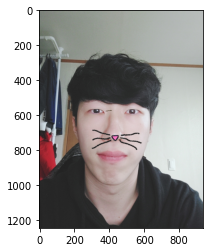

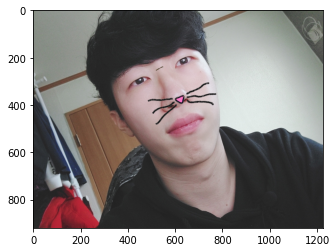

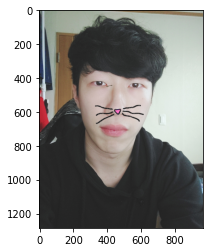

In [21]:
my_selca_2(my_image_path_1)
my_selca_2(my_image_path_2)
my_selca_2(my_image_path_3)

In [22]:
#거의 눕다시피한 이미지는 모델이 잘 찾을 수 없는것을 볼 수 있다.
my_selca_2(my_image_path_4)

UnboundLocalError: local variable 'w' referenced before assignment

## 회고합시다
* 고양이 수염이 어울리는 가장 적절한 좌표는 33번 랜드마크의 좌표입니다. 코 끝이 이미지의 중앙과 잘 겹칠 수 있도록 y좌표에 스티커의 높이의 절반을 더해 코 끝과 맞춰줍니다.  
* 얼굴 각도에 따라 스티커 이미지를 회전 시켜야 합니다. 저는 코 끝과 오른쪽 뺨의 랜드마크를 한 점으로 생각하고 중앙선과의 각도를 구해 스티커를 회전시켰습니다.
* 멀리서 촬영하거나 누워서 촬영하면 학습된 모델이 얼굴을 제대로 찾지 못합니다.